In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker
import ast
import json
from sklearn import preprocessing

In [26]:
%config IPCompleter.greedy=True
%matplotlib notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 10]

In [27]:
output_dir = "../output/vpp-rate"

measurements = list()

for direc, sub_direc, files in os.walk(output_dir):
    
    if files == []:
        continue
        
    if 'old' in direc:
        continue
        
    t = dict()
    
    for file in files:
        
        label, flows, repeat = direc.replace(output_dir, '').split('/')
        
        if 'vpp' in file:
            rx_rate_str = 'rx_rate_L1'
            tx_rate_str = 'tx_rate_L1'

            with open(direc + '/' + file, "r") as f:
                for line in f.readlines():
                    p = line.strip().split()
                    if '/interfaces/dev0/rx-miss' in p[-1] and '0' in p[2] and '0' in p[0]:
                        misses = int(p[3])

                    if len(p) > 2 and  '/err/dev1-tx/Tx' in p[2] and '[@2]' in p[0]:
                        drops = int(p[1])

                
        if 'p4tg' in file:
            with open(direc + '/' + file, "r") as f:
                contents = f.read().replace("\n", "").replace("\'", "\"")
                try:
                    t = ast.literal_eval(contents)
                except SyntaxError:
                    #print(direc + '/' + files[0])
                    continue

            app1 = t['app_rx_l2']['288']['1']
            app2 = t['app_rx_l2']['288']['2']
    
    measurements.append(
    {
        'total_rx_L1': t['rx_rate_l1']['288'],
        'total_tx_L1': int(t['tx_rate_l1']['288']/1000000000),
        'stream': 1,
        'rx_l2': app1/1000000,
        'misses': misses,
        'drops': drops,
        'flows': float(flows),
    })
    measurements.append(
    {
        'total_rx_L1': t['rx_rate_l1']['288'],
        'total_tx_L1': int(t['tx_rate_l1']['288']/(10**9)),
        'stream': 2,
        'rx_l2': app2/(10**6),
        'misses': misses,
        'drops': drops,
        'flows': float(flows),
    })

measurements_df = pd.DataFrame(measurements)

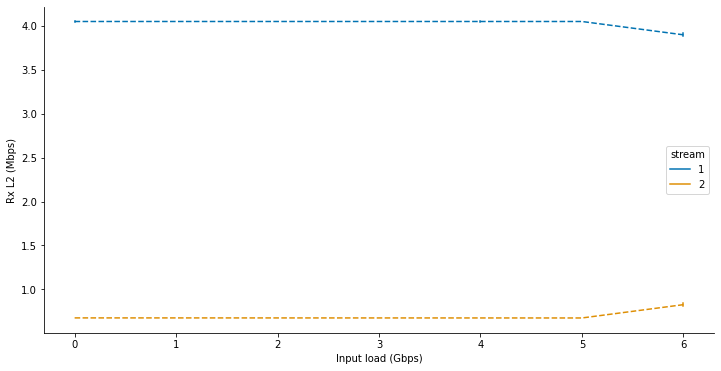

In [21]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

sns.lineplot(
    data = measurements_df,
    x = 'total_tx_L1',
    y = 'rx_l2',
    hue = 'stream',
    ax = ax1,
    palette = 'colorblind',
    linestyle = '--',
    ci = 'sd',
    err_style = 'bars'
)

ax1.set(
    ylabel = 'Rx L2 (Mbps)',
    xlabel = 'Input load (Gbps)'
)

sns.despine()

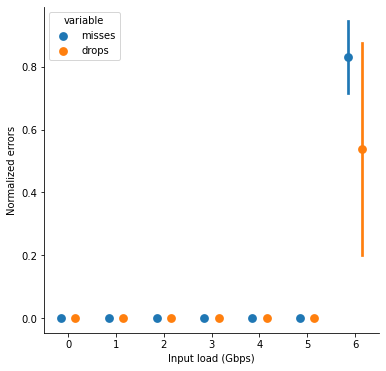

In [136]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

columns = ['misses', 'drops']
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(t)
measurements_df[columns] = min_max_scaler.fit_transform(measurements_df[columns])
t = measurements_df[['total_tx_L1','misses', 'drops' ]].dropna()
error_df = pd.melt(t, id_vars = 'total_tx_L1', value_vars = columns)

sns.pointplot(
    data = error_df,
    x = 'total_tx_L1',
    y = 'value',
    hue = 'variable',
    ax = ax1,
    linestyle = '--',
    ci = 'sd',
    err_style = 'bars',
    #label = 'Misses',
    join = False,
    pallette = 'colorblind',
    dodge = 0.3,
)

ax1.set(
    ylabel = 'Normalized errors',
    xlabel = 'Input load (Gbps)',
) 
#ax1.legend()
sns.despine()

The maximum error free input rate is ~5 Gbps.

Test 1.1 - How many flows/ sessions does the DPDK QoS support, while targeting a maximum load of 5 Gbps?

In [6]:
output_dir = "../output/vpp-flows"

measurements = list()

for direc, sub_direc, files in os.walk(output_dir):
    
    if files == []:
        continue
        
    if 'old' in direc:
        continue
        
    t = dict()
    
    for file in files:
        
        label, flows, repeat = direc.replace(output_dir, '').split('/')
        
        if 'vpp' in file:
            rx_rate_str = 'rx_rate_L1'
            tx_rate_str = 'tx_rate_L1'

            with open(direc + '/' + file, "r") as f:
                for line in f.readlines():
                    p = line.strip().split()
                    if '/interfaces/dev0/rx-miss' in p[-1] and '0' in p[2] and '0' in p[0]:
                        misses = int(p[3])

                    if len(p) > 2 and  '/err/dev1-tx/Tx' in p[2] and '[@2]' in p[0]:
                        drops = int(p[1])
                        
        if 'trex' in file:
            with open(direc + '/' + file, "r") as f:
                contents = f.read().replace("\n", "").replace("\'", "\"")
                try:
                    t = ast.literal_eval(contents)
                except SyntaxError:
                    print(direc + '/' + files[0])
                    continue              
    
    measurements.append(
    {
        'total_rx_L1': t['total']['rx_bps_L1'],
        'total_tx_L1': int(t['total']['tx_bps_L1']/1000000000),
        'total_tx_pps': int(t['total']['tx_pps']),
        'total_rx_pps': int(t['total']['rx_pps']),
        'flows': float(flows),
        'misses': misses,
        'drops': drops,

    })

measurements_df = pd.DataFrame(measurements)

[Text(0, 0.5, 'Total Session L1 throughput (Gbps)'), Text(0.5, 0, 'Sessions')]

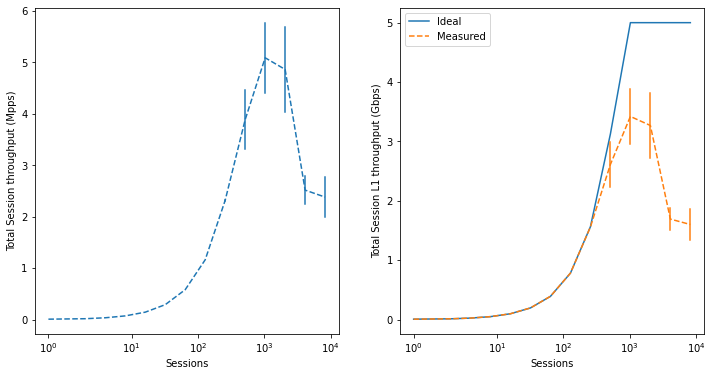

In [7]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

d = np.array(list(measurements_df['flows']))
ideal_d = list()

for i in d*762939*8/1000000000:
    if i > 5:
        ideal_d.append(5)
    else:
        ideal_d.append(i)

ax1.set_xscale('symlog')
ax2.set_xscale('symlog')

sns.lineplot(
    data = measurements_df,
    x = 'flows',
    y = measurements_df['total_rx_pps']/(10**6),
    ax = ax1,
    palette = 'colorblind',
    linestyle = '--',
    ci = 'sd',
    err_style = 'bars'
)

ax1.set(
    ylabel = 'Rx (Mpps)',
    xlabel = 'Sessions'
)

sns.lineplot(
    data = measurements_df,
    x = 'flows',
    y = ideal_d,
    ax = ax2,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    label = 'Ideal',
)

sns.lineplot(
    data = measurements_df,
    x = 'flows',
    y = measurements_df['total_rx_L1']/(10**9),
    ax = ax2,
    palette = 'colorblind',
    linestyle = '--',
    ci = 'sd',
    err_style = 'bars',
    label = 'Measured',
)

ax1.set(
    ylabel = 'Total Session throughput (Mpps)',
    xlabel = 'Sessions'
)

ax2.set(
    ylabel = 'Total Session L1 throughput (Gbps)',
    xlabel = 'Sessions'
)

[Text(0, 0.5, 'Errors '), Text(0.5, 0, 'Sessions')]

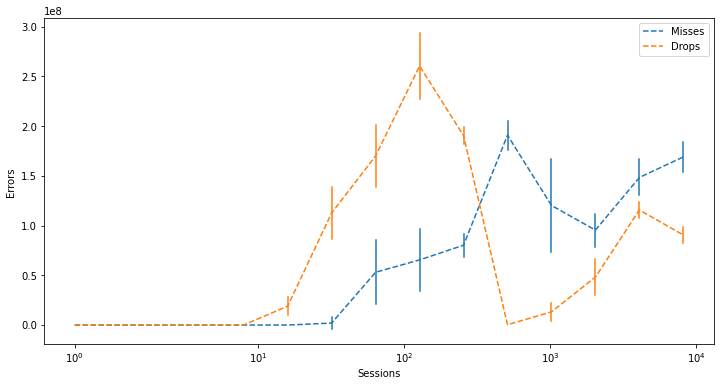

In [8]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

ax1.set_xscale('symlog')
sns.lineplot(
    data = measurements_df,
    x = 'flows',
    y = 'misses',
    ax = ax1,
    palette = 'colorblind',
    linestyle = '--',
    ci = 'sd',
    err_style = 'bars',
    label = 'Misses',
)


sns.lineplot(
    data = measurements_df,
    x = 'flows',
    y = 'drops',
    ax = ax1,
    palette = 'colorblind',
    linestyle = '--',
    ci = 'sd',
    err_style = 'bars',
    label = 'Drops',
)


ax1.set(
    ylabel = 'Errors ',
    xlabel = 'Sessions'
)

In [9]:
output_dir = "../output/vpp-flows"

measurements = list()

for direc, sub_direc, files in os.walk(output_dir):
    
    if files == []:
        continue
        
    if 'old' in direc:
        continue
        
    t = dict()
    
    for file in files:
        
        label, flows, repeat = direc.replace(output_dir, '').split('/')
        
        if 'vpp' in file:
            rx_rate_str = 'rx_rate_L1'
            tx_rate_str = 'tx_rate_L1'

            with open(direc + '/' + file, "r") as f:
                for line in f.readlines():
                    p = line.strip().split()
                    if '/interfaces/dev0/rx-miss' in p[-1] and '0' in p[2] and '0' in p[0]:
                        misses = int(p[3])

                    if len(p) > 2 and  '/err/dev1-tx/Tx' in p[2] and '[@2]' in p[0]:
                        drops = int(p[1])
                        
        if 'trex' in file:
            with open(direc + '/' + file, "r") as f:
                contents = f.read().replace("\n", "").replace("\'", "\"")
                try:
                    t = ast.literal_eval(contents)
                except SyntaxError:
                    print(direc + '/' + files[0])
                    continue              
    
    measurements.append(
    {
        'total_rx_L1': t['total']['rx_bps_L1'],
        'total_tx_L1': int(t['total']['tx_bps_L1']/1000000000),
        'total_tx_pps': int(t['total']['tx_pps']),
        'total_rx_pps': int(t['total']['rx_pps']),
        'flows': float(flows),
        'misses': misses,
        'drops': drops,

    })

measurements_df = pd.DataFrame(measurements)

[Text(0, 0.5, 'Total Session L1 throughput (Gbps)'), Text(0.5, 0, 'Sessions')]

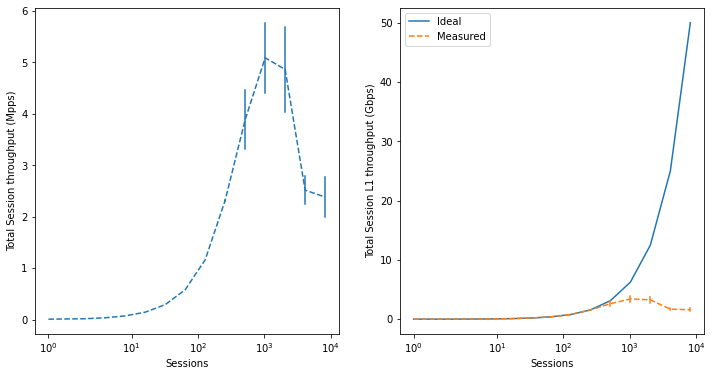

In [10]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

d = np.array(list(measurements_df['flows']))
ideal_d = list()
for i in d*762939*8/1000000000:
    ideal_d.append(i)

ax1.set_xscale('symlog')
ax2.set_xscale('symlog')

sns.lineplot(
    data = measurements_df,
    x = 'flows',
    y = measurements_df['total_rx_pps']/(10**6),
    ax = ax1,
    palette = 'colorblind',
    linestyle = '--',
    ci = 'sd',
    err_style = 'bars'
)

ax1.set(
    ylabel = 'Rx (Mpps)',
    xlabel = 'Sessions'
)

sns.lineplot(
    data = measurements_df,
    x = 'flows',
    y = ideal_d,
    ax = ax2,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    label = 'Ideal',
)

sns.lineplot(
    data = measurements_df,
    x = 'flows',
    y = measurements_df['total_rx_L1']/(10**9),
    ax = ax2,
    palette = 'colorblind',
    linestyle = '--',
    ci = 'sd',
    err_style = 'bars',
    label = 'Measured',
)

ax1.set(
    ylabel = 'Total Session throughput (Mpps)',
    xlabel = 'Sessions'
)

ax2.set(
    ylabel = 'Total Session L1 throughput (Gbps)',
    xlabel = 'Sessions'
)

In [11]:
measurements_df.set_index('flows').sort_index()

,total_rx_L1,total_tx_L1,total_tx_pps,total_rx_pps,misses,drops
flows,,,,,,
1.0,6.100001e+06,5,7444370,9077,2596,0
1.0,6.109068e+06,4,7436588,9091,5346,0
1.0,6.108993e+06,4,7430636,9090,3072,0
1.0,6.102738e+06,5,7447759,9081,6276,0
1.0,6.134743e+06,4,7437185,9129,4056,0
...,...,...,...,...,...,...
8192.0,1.559287e+09,4,6649052,2320367,159053563,96896110
8192.0,1.898345e+09,4,6676150,2824919,179518032,92142910
8192.0,1.528526e+09,4,6647697,2274591,167152690,83669456
